## Introduction to Deep Learning
# Part 3 - Multiple Layer Neural Networks
### Delta rule for learning, Gradient Decent and backpropogation

In [159]:
import matplotlib.pyplot as plt
import numpy as np
import utils_plot as uplot
import matplotlib.gridspec as gridspec
from sklearn.metrics import accuracy_score, log_loss
%matplotlib inline  

Networks without hidden units are very limited in what they can learn to model. What we need is multiple layers of non-linear hidden units. <br>
The chalange is: **how to train such netorks ?**<br>
We need a way to update all the weights not just the last layer like in a perceptron. It is a hard problem, and it took the researchers 20 years to find the right method. <br>


![title](https://raw.githubusercontent.com/naomifridman/Introduction_to_deep_learning/master/imgs/training_model.png)
Any hidden unit, can affect many other units, and affect the results, in many ways. So we use a method to combine all those effects, and focus on investigating the efect, the weight have, on the overall error.<br>

The aim of the learning is to minimize the error summed (or meaned) over all training cases. <br>
To achive that,we need a **measure** of that error. For simplicity, we will use the square difference between the target output and the actual output. 

#### Squared loss: a popular loss function
The squared loss (also known as L2 loss), is the squered distance between the prediction and the true lable. <br>
Lets mark:
* $x\, -\, The\, input$
* $\hat{y}\, or \,y'\, - \,The\, true\, lables$<br>
* $y = predictions(x) = f(x)\; Model's\,  predictions$<br>

The squared loss for a single example is: ${(\hat{y} - y)}^2$<br>

 
#### Mean square error (MSE) 
is the average squared loss per example over the whole dataset. 
To calculate MSE, sum up all the squared
losses for individual examples and then divide by the number of examples:
    $$ MSE = \frac{1}{N} \sum_{(x,y)\in D} (y - f(x))^2 $$
> MSE is popular in machine learning, mainly from historical reasons, since all the math was initially calculated with MSE. But it is not neccesery the best. For different problems, there are other practical loss functions that performs better.

#### The goal of training a model is to find a set of weights that produce a minimal loss, on average, across all examples.


To find the minimum of the loss function, we will use An iterative method. <br>
Iterative methods, are usually less efficient, but much easier to generalize.

## Gradient Decent - Minimize loss function iterativly 
Intuition: Imagine you stand in a canyon, or a bowl, and you want to get to the lowest point. If you walk in small steps towards the stipest part, this will get you to the lowest point, if the canyon (or the bowl) is convex.
![title](https://raw.githubusercontent.com/naomifridman/Introduction_to_deep_learning/master/imgs/dune11.jpg)
### Delta rule for learning
This intuition is defined as the delta rule.
$$ \Delta{w_{i}} = \alpha*(derivative\, of\, the \,loss\, function)$$

* $\alpha$ - learning rate, is the (small) size of the step.

The weights update will be:
$$ W_{new} = W_{old} - \Delta{w_{i}}$$



But how do we implement the delta rule for a multi layer network ?
This implementation is called backpropogation. Backpropagation, is an abbrevation for “backward propagation of errors”, is a mechanism used to update the weights using gradient descent. It calculates the gradient of the error function with respect to the neural network’s weights. The calculation proceeds backwards through the network.

## Backpropagation
Back propogation,is a method to propogatate the error, back to the weights, and update them in away that will minimize the error.<br>
Math is simple algebra, but there are some indexing to follow. Since most of us will not code the backpropopgation manually, The coded is illustrative, specific and not too general. Still you can play with the coded example and test different parameters and data sets.<br>
To implement backpropogation example, Lets start with our Logic OR example.
![title](https://raw.githubusercontent.com/naomifridman/Introduction_to_deep_learning/master/imgs/mlp1j11.JPG)
### Step 1. Initialize network
For simplicity, we choose all activation functions to be Sigmoid function. For clarity, We will cal the weighted input sum to a neuron: net, and the Sigmoid applied on the this sum will be called: out.
![title](https://raw.githubusercontent.com/naomifridman/Introduction_to_deep_learning/master/imgs/neuron_in_out.JPG)
Build and Initialize network with random weights:

In [160]:
# Initialize a network
n_inputs = 3
n_hidden = 2

def initialize_network():
    
    network = {'n_inputs':n_inputs,'n_hidden':n_hidden,
               'n_outputs':1,
               'hidden_layer_weights':\
               [[np.random.random() for i in range(n_inputs)] for i in range(n_hidden)],
              'output_layer_weights':\
              [np.random.random() for i in range(n_hidden)],
               
              'output_layer_net':0.,
              'hidden_net':\
               [0. for i in range(n_hidden)],
               'hidden_out':\
               [0. for i in range(n_hidden)],
               'output_layer_out':0.
              }
    
    return network

In [161]:
def print_network(network):
    print('hidden_layer_weights:')
    
    for i in range(n_hidden):
        print('h{} weights:{}'.format(i, network['hidden_layer_weights'][i]))
        print('h{} net:{:.4f}'.format(i, network['hidden_net'][i]))
        print('h{} out:{:.4f}'.format(i, network['hidden_out'][i]))
    print('output_layer_weights: {}'.format(network['output_layer_weights']))
    print('output layer net: {:.4f}'.format(network['output_layer_net']))
    print('Output: {:.4f}'.format(network['output_layer_out']))

In [162]:
np.random.seed(0)
network = initialize_network()
print_network(network)

hidden_layer_weights:
h0 weights:[0.5488135039273248, 0.7151893663724195, 0.6027633760716439]
h0 net:0.0000
h0 out:0.0000
h1 weights:[0.5448831829968969, 0.4236547993389047, 0.6458941130666561]
h1 net:0.0000
h1 out:0.0000
output_layer_weights: [0.4375872112626925, 0.8917730007820798]
output layer net: 0.0000
Output: 0.0000


### Step 2. Forward pass

In [163]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [164]:
# Forward pass: propagate input to a network output
def forward_propagate(network, inputs):
    new_inputs = []
    for i in range(network['n_hidden']):
        #print('i',i, network['hidden_layer_weights'][i])
        #print(inputs)
        network['hidden_net'][i] = np.dot(network['hidden_layer_weights'][i],
                                                inputs)
        network['hidden_out'][i] = sigmoid(network['hidden_net'][i])
    
   
    net = np.dot(network['output_layer_weights'], 
                 [network['hidden_out'][i] for i in range(n_hidden)])
    out = sigmoid(net)
    network['output_layer_net'] = net
    network['output_layer_out'] = out
    
    return out


In [165]:
output = forward_propagate(network, [1, 0, 1])

In [166]:
print_network(network)


hidden_layer_weights:
h0 weights:[0.5488135039273248, 0.7151893663724195, 0.6027633760716439]
h0 net:1.1516
h0 out:0.7598
h1 weights:[0.5448831829968969, 0.4236547993389047, 0.6458941130666561]
h1 net:1.1908
h1 out:0.7669
output_layer_weights: [0.4375872112626925, 0.8917730007820798]
output layer net: 1.0164
Output: 0.7343


## Step 3. Backpropogation
To apply the delta rule for learning, we need todefine a loss function. Lets use the simple known squere error:
$$E_{total} = \frac{1}{2}(target - output)^{2}$$
To update weights, according to delta rule, we need to calculate the "influence"of each weight onthe target. Mathematicly, we need to calculate the partial derivativeof the error, with respect to each weight. <br>
Lets mark the weights in our network , and rename input layer to $I_i$:
![title](https://raw.githubusercontent.com/naomifridman/Introduction_to_deep_learning/master/imgs/mlp_2hidden_1ou_weightst.jpg)

#### Backpropogationg error for output layer
Consider $w_1$, We want to know how much a change in $w_7$ affects the total error, aka, $\frac{\partial E_{total}}{\partial w_{1}}$

Using chane rule, we will get:
$$\frac{\partial E_{total}}{\partial w_{1}} = \frac{\partial E_{total}}{\partial out_o} * 
\frac{\partial out_o}{\partial net_{o}} *
\frac{\partial net_{o}}{\partial w_{1}}$$

$$E_{total}=(target - output)^{2 }$$
$$output = out_o$$

$$\frac{\partial E_{total}}{\partial out_o} = 2 * \frac{1}{2}(target - out_o)^{2 - 1} * -1 =(out_o-target)$$

We chose Sigmoid activation, wich derivative is:
$$\frac{d}{dx}Sigmoid(x) = Sigmoid(x)(1 - Sigmoid(x))$$
* detailes https://beckernick.github.io/sigmoid-derivative-neural-network/

And since:




$$output = out_o = \frac{1}{1+e^{-net_{o}}}$$
We get:

$$\frac{\partial out_o}{\partial net_{o}} = out_o*(1-out_o)$$

$$net_{o} = out_{h0}*w_0 + out_{h1}*w_1$$    

$out_{h0}$ ho has no dependence in $w_{1}$, So:
$$\frac{\partial net_{o}}{\partial w_{1}} = out_{h1}$$    


Putting it all together, we get:

$$\frac{\partial E_{total}}{\partial w_{1}} = \frac{\partial E_{total}}{\partial out_o} * 
\frac{\partial out_o}{\partial net_{o}} *
\frac{\partial net_{o}}{\partial w_{1}} =  -(target-out_o)*
out_o*(1-out_o)*
out_{h1}
$$

So according to delta rule, to decrease error, we update $w_1$:
$$w_1^{new} = w_1 + \Delta* (target-out_o)*  out_o*(1-out_o)*out_{h1}$$

In the same, we can calculate update for $w_0$:
$$w_0^{new} = w_0 + \Delta* (target-out_o)*  out_o*(1-out_o)*out_{ho}$$

Lets mark:
$$ \delta_{o} = out_o*(1-out_o)$$

We get:
$$w_0^{new} = w_0 + \Delta* \delta_{o}*out_{ho}*(target-output)$$

$$w_1^{new} = w_1 + \Delta* \delta_{o}*out_{h1}*(target-output)$$

#### Backpropogationg error for hidden layer
In a similar way, lets calculate: $\frac{\partial E_{total}}{\partial w_{12}}$

$$\frac{\partial E_{total}}{\partial w_{12}} = [\frac{\partial E_{total}}{\partial out_{o}} * 
\frac{\partial out_{o}}{\partial net_{o}}] * 
\frac{\partial net_{o}}{\partial out_{h1}} * 
\frac{\partial out_{h1}}{\partial net_{h1}} *
\frac{\partial net_{h1}}{\partial w_{12}} $$

$$\frac{\partial E_{total}}{\partial w_{12}} = -[\delta_{out}*out_{h1}*(target-output)]*\frac{\partial net_{o}}{\partial out_{h1}} * 
\frac{\partial out_{h1}}{\partial net_{h1}} *
\frac{\partial net_{h1}}{\partial w_{12}} $$

$$net_{o} = out_{h0}*w_0 + out_{h1}*w_1$$   

$$\frac{\partial net_{o}}{\partial out_{h1}} = w_1$$

$$\frac{\partial out_{h1}}{\partial net_{h1}} = out_{h1}*(1-out_{h1})=\delta_{h1}$$

$$\frac{\partial net_{h1}}{\partial w_{12}} = I_{2}$$

Putting it all together, we get:

$$\frac{\partial E_{total}}{\partial w_{11}} = -(target-output)*\delta_{out}*out_{h1}*w_1*\delta_{h1}*I_1$$

$$\frac{\partial E_{total}}{\partial w_{10}} = -(target-output)*\delta_{out}*out_{h1}*w_1*\delta_{h1}*I_0$$

$$\frac{\partial E_{total}}{\partial w_{00}} = -(target-output)*\delta_{out}*out_{h0}*w_0*\delta_{h0}*I_0$$

We can write, general update rule for hidden layerofour network:

$$\frac{\partial E_{total}}{\partial w_{ij}} = -(target-output)*\delta_{o}*out_{hi}*w_i*\delta_{hi}*I_j$$

So, update rule for hidden layer weights, will be:

$$w^{new}_{ij} = w_{ij} + \Delta *(target-output)*\delta_{o}*out_{hi}*w_i*\delta_{hi}*I_j$$

In [167]:
def delta(x):    
    return x * (1 - x)

In [168]:
# Backpropagate error and update weights
def backward_propagate_error(network, inputs, output, target, lr = 0.5):
    
    delta_o = delta(output)

    for i in range(n_hidden):

        # lets mark: update_i = delta_o*out_hi*(target - output)
        update_i = delta_o * network['hidden_out'][i] * (target - output)
               
        # update hidden layer weights        
        # We get: w_new_ij = w_ij + lr*update_i*w_i*delta_hi*Ij
        for j in range(n_inputs):
            w_i = network['output_layer_weights'][i]
            out_hi = network['hidden_out'][i]
            update_ij = update_i*w_i*delta(out_hi)*inputs[j]
            network['hidden_layer_weights'][i][j] += lr*update_ij
       
        # update output layer weights
        # w_new_i = w_i + lr*delta_o*out_hi*(target - output)
        # w_new_i = w_i + lr*update_i
        network['output_layer_weights'][i] +=  lr * update_i    
        
    

Some Test of back propogation

In [169]:
inputs = [1,0,0]
target = 0
output = forward_propagate(network, inputs)
print_network(network)
backward_propagate_error(network, inputs, output, target)
print_network(network)

hidden_layer_weights:
h0 weights:[0.5488135039273248, 0.7151893663724195, 0.6027633760716439]
h0 net:0.5488
h0 out:0.6339
h1 weights:[0.5448831829968969, 0.4236547993389047, 0.6458941130666561]
h1 net:0.5449
h1 out:0.6329
output_layer_weights: [0.4375872112626925, 0.8917730007820798]
output layer net: 0.8418
Output: 0.6988
hidden_layer_weights:
h0 weights:[0.5440795950731664, 0.7151893663724195, 0.6027633760716439]
h0 net:0.5488
h0 out:0.6339
h1 weights:[0.5352395813873537, 0.4236547993389047, 0.6458941130666561]
h1 net:0.5449
h1 out:0.6329
output_layer_weights: [0.39097337104818664, 0.8452262752812989]
output layer net: 0.8418
Output: 0.6988


## Step 4. Train network

In [191]:
def train_network(network, train, targets, l_rate, n_epoch, verbose=0):
    
    epoch_error = []
    #print('in train_error')
    for epoch in range(n_epoch):
        sum_error = 0
        for inputs,target in zip(train,targets):
            #print('inputs', inputs)
            #print_network(network)
            output = forward_propagate(network, inputs)
            # update the weights according to error in the output
            sum_error += np.sum((target-output)**2)
            backward_propagate_error(network, inputs, output, target)
        epoch_error.append(sum_error)
        if (verbose):
            print('>epoch=%d,  error=%.3f' % (epoch, sum_error))
    return epoch_error

In [192]:
output = forward_propagate(network, [1, 0, 1])
print_network(network)

hidden_layer_weights:
h0 weights:[1.182997157804538, 0.6779375271863188, 0.5570052393625283]
h0 net:1.7400
h0 out:0.8507
h1 weights:[-1.0888274097002848, 3.089542503892458, 3.137135989986509]
h1 net:2.0483
h1 out:0.8858
output_layer_weights: [-2.4216395088721843, 4.428352748898924]
output layer net: 1.8625
Output: 0.8656


#### Lets train the network on Logic OR 
* Inputs are $[bias=1, X_0, X_1]$
* Targets are:  $X_0 \vee X_1$

In [193]:
np.random.seed(0)
train_set = [[1,0.,0],
    [1.,0.,1.],
    [1, 1.,1.],
    [1.,1.,0]]
targets = [0, 1, 1, 1]
network = initialize_network()
epoch_error = train_network(network=network, train=train_set,
                            targets=targets,
                            l_rate=0.5, n_epoch=600)


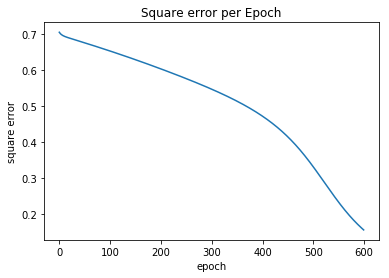

In [194]:
plt.plot(epoch_error)
plt.ylabel('square error')
plt.xlabel('epoch')
plt.title('Square error per Epoch')
plt.show()

## Step 4. Predict

In [195]:
# Make a prediction with the trained  network
def predict(network, inputs):
    outputs = forward_propagate(network, inputs)
    return outputs

In [196]:
for inputs in train_set:
    prediction = predict(network, inputs)
    print(inputs,prediction)

[1, 0.0, 0] 0.32333241162106896
[1.0, 0.0, 1.0] 0.8655849465367054
[1, 1.0, 1.0] 0.8983473668822205
[1.0, 1.0, 0] 0.858770021234528


>### Remarks on weight update
There are few ways to update the weights. 
* Stochastic Gradient Descent
In Stochastic gradient descent, often abbreviated as SGD, the error is calculated , and the weights are updated for each example in the training dataset.<br>
I used this method here, since its clear and ilustrative, and the toy data set,is very small.
* Batch Gradient Descent
In Batch gradient descent the error is calculated for each example in the training dataset, but the weights are updated after a pass on all training examples.
* Mini-Batch Gradient Descent
In Mini-batch gradient descent we split the training dataset into small batches. The error is calculated ,as a sum or a mean, for each mini batch, and weights are updated after each minibatch.

As we can see, to build practical neural networks for real problems, 
we better off using deep learning library.
Keras is great library to start with. An ilstrutive example in the next part.
* https://keras.io/

### Learn more:
* This part was written as an attempt to understand Hinton's lecture: https://www.coursera.org/learn/neural-networks/lecture/bD3OB/learning-the-weights-of-a-linear-neuron-12-min
* Google machine learning course https://developers.google.com/machine-learning/crash-course/reducing-loss/gradient-descent